In [1]:
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.preprocessing import StandardScaler

from joblib import dump, load
import pandas as pd
import numpy as np

from psyke import Extractor, Clustering, Target
from psyke.extraction.hypercubic.strategy import AdaptiveStrategy
from psyke.extraction.hypercubic import Grid, FeatureRanker
from psyke.utils.logic import pretty_theory

from plot import *

In [21]:
def plot(testB, x, pred, extracted):
    missing = pd.read_csv("data/missing.csv", parse_dates = [0], index_col = 0)
    df = pd.read_csv("data/averaged1.csv", parse_dates = [0], index_col = 0)
    df.LPFnorm[missing.index] = np.nan

    for i, b in bartels.iterrows():
        if b.n != testB:
            continue
        xminmax = [b.t0, b.t1]

        f, axes = plt.subplots(3, figsize=(10, 8)) # l x h

        myplot(axes[0], [3, 1], "LPF", df.index, df.LPFnorm, xminmax)
        myplot(axes[0], [3, 1], "", missing.index, missing.LPF0, xminmax, color='r', marker='*', lw=0, size=10)
        myplot(axes[1], [3, 2], "V", df.index, df.V, xminmax)
        myplot(axes[1], [3, 2], "", x, pred, xminmax, color='b', marker='.', lw=0)
        myplot(axes[1], [3, 2], "", x, extracted, xminmax, color='r', marker='.', lw=0)
        myplot(axes[2], [3, 3], "B", df.index, df.B, xminmax)
        plt.subplots_adjust(hspace=0.6)
        plt.savefig(f"plot/{b.n}.jpg", dpi=96 * 2)
        plt.show()

In [2]:
def getTrainTest(data, testB):
    b = bartels[bartels.n==testB]
    t0, t1 = b.t0.values[0], b.t1.values[0]
    idx = (data.index >= t0) & (data.index < t1)
    return data[~idx], data[idx]

def getScaler(train, name):
    scaler = StandardScaler().fit(train)
    dump(scaler, f"scalers/scalerV{name}.joblib")
    normalization = {key: (m, s) for key, m, s in zip(train.columns, scaler.mean_, scaler.scale_)}
    return scaler, pd.DataFrame(scaler.transform(train), columns=train.columns), normalization

In [30]:
def gridex(model, train, test, normalization):
    ranked = FeatureRanker(train.columns).fit(model, train.iloc[:, :-1]).rankings()
    gridEx = Extractor.gridex(model, Grid(1, AdaptiveStrategy(ranked, [(0.6, 3), (0.75, 4)])),
                              threshold=.5, min_examples=1, normalization=normalization)
    gridEx.extract(train)
    return gridEx.brute_predict(test), gridEx.n_rules, sum([p is None for p in gridEx.predict(test)])
    
def gridrex(model, train, test, normalization):
    ranked = FeatureRanker(train.columns).fit(model, train.iloc[:, :-1]).rankings()
    gridREx = Extractor.gridrex(model, Grid(1, AdaptiveStrategy(ranked, [(0.5, 3)])),
                                threshold=.5, min_examples=1, normalization=normalization)
    gridREx.extract(train)
    return gridREx.brute_predict(test, 'default'), gridREx.n_rules, sum([p is None for p in gridREx.predict(test)])

def cart(model, train, test, normalization):
    CART = Extractor.cart(model, max_depth=5, max_leaves=7, normalization=normalization)
    CART.extract(train)
    return CART.predict(test), CART.n_rules, sum([p is None for p in CART.predict(test)])

def cosmik(model, train, test, normalization):
    COSMiK = Extractor.cosmik(model, max_components=10, k=150, patience=10, close_to_center=True,
                              output=Target.REGRESSION, normalization=normalization)
    COSMiK.extract(train)
    return COSMiK.brute_predict(test, 'default'), COSMiK.n_rules, sum([p is None for p in COSMiK.predict(test)])

def creepy(model, train, test, normalization):
    CReEPy = Extractor.creepy(model, clustering=Clustering.cream, depth=5, error_threshold=.5, gauss_components=10,
                              output=Target.REGRESSION, normalization=normalization)
    CReEPy.extract(train)
    return CReEPy.brute_predict(test), CReEPy.n_rules, sum([p is None for p in CReEPy.predict(test)])

In [31]:
bartels = pd.read_csv("data/bartels.csv", parse_dates = [1, 2])

extractors = ['GridEx', 'GridREx', 'CART', 'COSMiK', 'CReEPy']

TESTB = [i for i in range(2491, 2509)]

predicted = {name: [] for name in ['index', 'V', 'model'] + extractors}

rules = {name: [] for name in ['BR'] + extractors}

missed = {name: [] for name in ['BR'] + extractors}

for testB in TESTB:
    rules['BR'].append(testB)
    missed['BR'].append(testB)
    print(testB)

    data = pd.read_csv(f'data/halffuzzycoefs2B.csv', parse_dates=[0], index_col=0)
    train, test = getTrainTest(data, testB)

    predicted['index'] += list(test.index.values)
    predicted['V'] += list(test.V.values)

    scaler, scaledTrain, normalization = getScaler(train, f"test{testB}")
    scaledTest = pd.DataFrame(scaler.transform(test), columns=test.columns).iloc[:, :-1]
    m, s = normalization[test.columns[-1]]

    model = KNN(200, weights='distance', p=1).fit(scaledTrain.iloc[:, :-1], scaledTrain.iloc[:, -1])
    #dump(model, f"models/RF/{k}_{name}_{testB}.joblib")
    predicted['model'] += list(model.predict(scaledTest) * s + m)

    for name, fun in zip(extractors, [gridex, cart, cart, cosmik, creepy]):
        print(name)
        #if name in ['GridREx', 'CART', 'COSMiK']:
        #    continue
        pred, n, miss = fun(model, scaledTrain, scaledTest, normalization)
        predicted[name] += list(pred)
        rules[name].append(n)
        missed[name].append(miss)

    break

2491
GridEx
GridREx
CART
COSMiK
CReEPy


KeyboardInterrupt: 

75.32443332103857 45.80166313557053
65.44680302846326 41.183118869594864
65.44680302846326 41.183118869594864
82.47813971748161 33.34135118914507
80.09439063082522 39.23197875360054


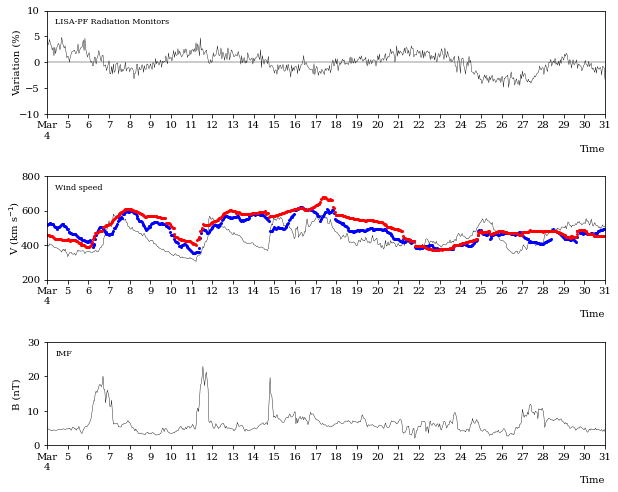

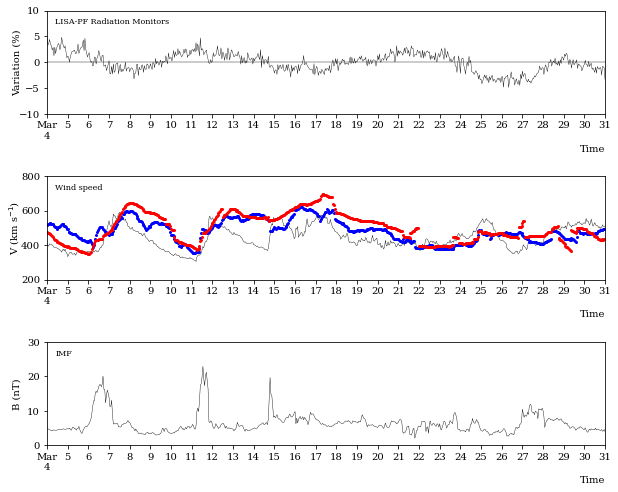

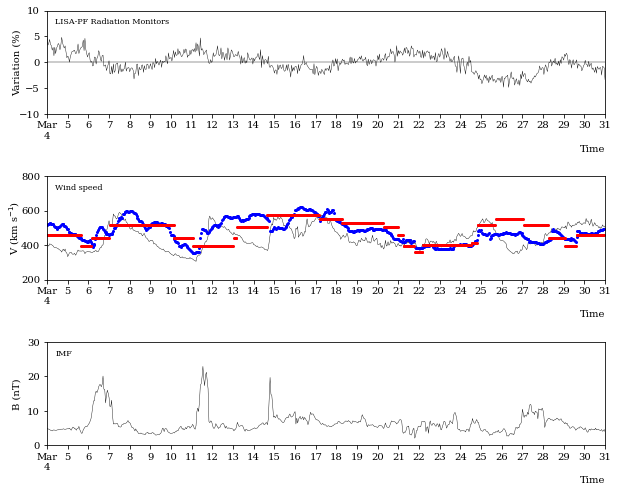

,index,V,model,GridEx,GridREx,CART,COSMiK,CReEPy
0,2016-03-04 00:00:00,410.0,518.750997,456.38289,441.865819,441.865819,462.073299,477.108816
1,2016-03-04 01:00:00,400.0,522.352090,456.38289,441.865819,441.865819,460.069181,473.640591
2,2016-03-04 02:00:00,395.0,525.129143,456.38289,441.865819,441.865819,457.718672,469.171813
3,2016-03-04 03:00:00,408.0,528.767307,456.38289,441.865819,441.865819,455.242336,465.418572
4,2016-03-04 04:00:00,406.0,528.091871,456.38289,441.865819,441.865819,454.052186,462.959830
...,...,...,...,...,...,...,...,...
643,2016-03-30 19:00:00,497.0,487.521085,456.38289,441.865819,441.865819,451.642998,432.796454
644,2016-03-30 20:00:00,501.0,489.614882,456.38289,441.865819,441.865819,452.503446,433.519832
645,2016-03-30 21:00:00,518.0,490.609540,456.38289,441.865819,441.865819,452.375362,432.264649
646,2016-03-30 22:00:00,510.0,491.321955,456.38289,441.865819,441.865819,452.801142,431.704527


In [24]:
p = pd.DataFrame(predicted)
for e in extractors:
    print(abs(p.V - p[e]).mean(), abs(p.model - p[e]).mean())

plot(2491, p['index'], p.model, p.COSMiK)
plot(2491, p['index'], p.model, p.CReEPy)
plot(2491, p['index'], p.model, p.GridEx)

p

In [39]:
pd.DataFrame(predicted).to_csv("results/pred1.csv")
pd.DataFrame(rules).to_csv('results/rules1.csv')
pd.DataFrame(missed).to_csv('results/missed1.csv')

In [ ]:
[
    ('half2', 1.0),
    ('Bmin', 0.9014926374248455),
    ('Bmedian', 0.5931779258652916),
    ('Bmax', 0.5580664110760513),

    ('trend', 0.441328536097858),
    ('max', 0.19391808653199277),
    ('median', 0.16157357528452515),

    ('halfB2', 0.06672545822303622),
    ('min', 0.042323799412967836),
    ('B', 0.014457395044254808),
    ('halfB1', 0.005159557201584083),
    ('half1', 0.0023286124765232786),
]

In [15]:
import pandas as pd

p = pd.read_csv('results/cartpredpruned.csv')
p = p[p.columns[2:]]
for c in p.columns[2:]:
    p[c] = abs(p[c] - p.model)
p.describe().loc['mean']

V          454.232082
model      454.416913
CART2       55.474434
CART5       39.939136
CART10      37.642059
CART25      36.371025
CART50      39.203983
CART75      40.454190
CART100     43.945508
CART150     47.059375
CART200     49.097016
CART250     51.038554
CART300     51.182619
CART400     52.651320
CART500     52.874986
CART600     53.924574
Name: mean, dtype: float64